<a href="https://colab.research.google.com/github/changhoonhahn/gqp_mc/blob/master/nb/training_desi_complexdust_speculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/speculator_fork

/content/drive/My Drive/speculator_fork


In [3]:
import os 
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from speculator import SpectrumPCA
from speculator import Speculator

In [4]:
# read DESI wavelength
wave = np.load('wave_fsps.npy')

In [5]:
n_param = 10
n_wave  = len(wave)
batches = '0_99'
n_pcas  = 30 

In [8]:
# load trained PCA basis object
print('training PCA bases') 
PCABasis = SpectrumPCA(
        n_parameters=n_param,       # number of parameters
        n_wavelengths=n_wave,       # number of wavelength values
        n_pcas=n_pcas,              # number of pca coefficients to include in the basis 
        spectrum_filenames=None,  # list of filenames containing the (un-normalized) log spectra for training the PCA
        parameter_filenames=[], # list of filenames containing the corresponding parameter values
        parameter_selection=None) # pass an optional function that takes in parameter vector(s) and returns True/False for any extra parameter cuts we want to impose on the training sample (eg we may want to restrict the parameter ranges)
PCABasis._load_from_file('DESI_complexdust.%s.seed0.pca%i.hdf5' % (batches, n_pcas))

training PCA bases


In [9]:
# train Speculator 
training_theta  = tf.convert_to_tensor(PCABasis.training_parameters.astype(np.float32))
training_pca    = tf.convert_to_tensor(PCABasis.training_pca.astype(np.float32))

speculator = Speculator(
        n_parameters=n_param, # number of model parameters 
        wavelengths=wave, # array of wavelengths
        pca_transform_matrix=PCABasis.pca_transform_matrix,
        parameters_shift=PCABasis.parameters_shift, 
        parameters_scale=PCABasis.parameters_scale, 
        pca_shift=PCABasis.pca_shift, 
        pca_scale=PCABasis.pca_scale, 
        spectrum_shift=PCABasis.spectrum_shift, 
        spectrum_scale=PCABasis.spectrum_scale, 
        n_hidden=[256, 256, 256], # network architecture (list of hidden units per layer)
        restore=False, 
        optimizer=tf.keras.optimizers.Adam()) # optimizer for model training

# cooling schedule
lr = [1e-3, 1e-4, 1e-5, 1e-6]
batch_size = [1000, 10000, 50000, 100000]#int(training_theta.shape[0])]
gradient_accumulation_steps = [1, 1, 1, 10] # split the largest batch size into 10 when computing gradients to avoid memory overflow

# early stopping set up
patience = 20

# train using cooling/heating schedule for lr/batch-size
for i in range(len(lr)):
    print('learning rate = ' + str(lr[i]) + ', batch size = ' + str(batch_size[i]))
    # set learning rate
    speculator.optimizer.lr = lr[i]

    # split into validation and training sub-sets
    n_training = training_theta.shape[0]

    # create iterable dataset (given batch size)
    training_data = tf.data.Dataset.from_tensor_slices((training_theta, training_pca)).shuffle(n_training).batch(batch_size[i])

    # set up training loss
    training_loss   = [np.infty]
    validation_loss = [np.infty]
    best_loss       = np.infty
    early_stopping_counter = 0

    # loop over epochs
    while early_stopping_counter < patience:

        # loop over batches
        for theta, pca in training_data:

            # training step: check whether to accumulate gradients or not (only worth doing this for very large batch sizes)
            if gradient_accumulation_steps[i] == 1:
                loss = speculator.training_step(theta, pca)
            else:
                loss = speculator.training_step_with_accumulated_gradients(theta, pca, accumulation_steps=gradient_accumulation_steps[i])

        # compute validation loss at the end of the epoch
        validation_loss.append(speculator.compute_loss(training_theta, training_pca).numpy())

        # early stopping condition
        if validation_loss[-1] < best_loss:
            best_loss = validation_loss[-1]
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            speculator.update_emulator_parameters()
            speculator.save('_DESI_complexdust_model.%s.pca%i.log' % (batches, n_pcas))

            attributes = list([
                    list(speculator.W_), 
                    list(speculator.b_), 
                    list(speculator.alphas_), 
                    list(speculator.betas_), 
                    speculator.pca_transform_matrix_,
                    speculator.pca_shift_,
                    speculator.pca_scale_,
                    speculator.spectrum_shift_,
                    speculator.spectrum_scale_,
                    speculator.parameters_shift_, 
                    speculator.parameters_scale_,
                    speculator.wavelengths])

            # save attributes to file
            f = open('DESI_complexdust_model.%s.pca%i.log.pkl' % (batches, n_pcas), 'wb')

            pickle.dump(attributes, f)
            f.close()
            print('Validation loss = %s' % str(best_loss))

learning rate = 0.001, batch size = 1000
Validation loss = 0.03279514
learning rate = 0.0001, batch size = 10000
Validation loss = 0.0142165795
learning rate = 1e-05, batch size = 50000
Validation loss = 0.013635943
learning rate = 1e-06, batch size = 1000000


KeyboardInterrupt: ignored

In [11]:
speculator = Speculator(restore=True, restore_filename='_DESI_complexdust_model.%s.pca%i.log' % (batches, n_pcas))

In [12]:
# read in training parameters and data
theta_test = np.load('DESI_complexdust.theta_test.npy')
logspectrum_test = np.load('DESI_complexdust.logspectrum_fsps_test.npy')
spectrum_test = 10**logspectrum_test

In [15]:
logspectrum_spec = speculator.log_spectrum(theta_test.astype(np.float32))
spectrum_spec = 10**logspectrum_spec

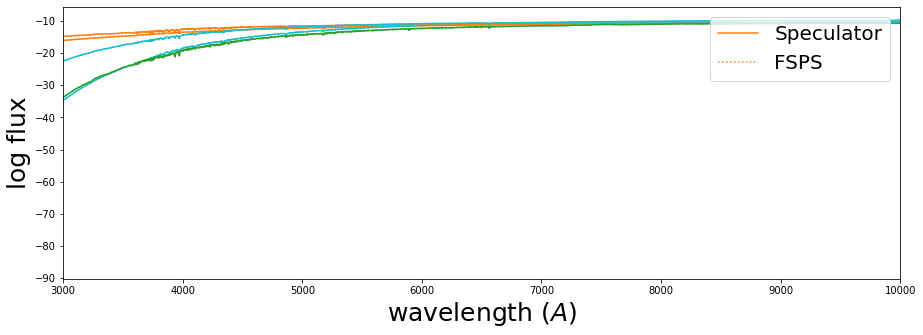

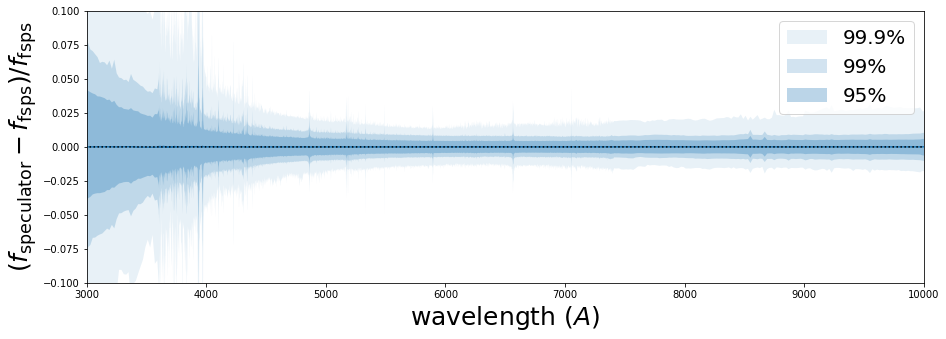

In [20]:
# figure comparing Speculator log spectrum to FSPS log spectrum  
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for ii, i in enumerate(np.random.choice(len(theta_test), size=5)): 
    sub.plot(wave, logspectrum_spec[i], c='C%i' % i, ls='-', label='Speculator')
    sub.plot(wave, logspectrum_test[i], c='C%i' % i, ls=':', label='FSPS')
    if ii == 0: sub.legend(loc='upper right', fontsize=20) 

sub.set_xlabel('wavelength ($A$)', fontsize=25) 
sub.set_xlim(3e3, 1e4)
sub.set_ylabel('log flux', fontsize=25) 
fig.savefig('validate_desi_complexdust.%s.pca%i.0.png' % (batches, n_pcas), bbox_inches='tight') 

# more quantitative accuracy test of the Speculator model 
frac_dspectrum = (spectrum_spec - spectrum_test) / spectrum_test 
frac_dspectrum_quantiles = np.nanquantile(frac_dspectrum, 
        [0.0005, 0.005, 0.025, 0.5, 0.975, 0.995, 0.9995], axis=0)

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.fill_between(wave, frac_dspectrum_quantiles[0],
        frac_dspectrum_quantiles[6], fc='C0', ec='none', alpha=0.1, label='99.9%')
sub.fill_between(wave, frac_dspectrum_quantiles[1],
        frac_dspectrum_quantiles[5], fc='C0', ec='none', alpha=0.2, label='99%')
sub.fill_between(wave, frac_dspectrum_quantiles[2],
        frac_dspectrum_quantiles[4], fc='C0', ec='none', alpha=0.3, label='95%')
sub.plot(wave, frac_dspectrum_quantiles[3], c='C0', ls='-') 
sub.plot(wave, np.zeros(len(wave)), c='k', ls=':') 
sub.legend(loc='upper right', fontsize=20)
sub.set_xlabel('wavelength ($A$)', fontsize=25) 
sub.set_xlim(3e3, 1e4)
sub.set_ylabel(r'$(f_{\rm speculator} - f_{\rm fsps})/f_{\rm fsps}$', fontsize=25) 
sub.set_ylim(-0.1, 0.1) 
fig.savefig('validate_desi_complexdust.%s.pca%i.1.png' % (batches, n_pcas), bbox_inches='tight') 